1. *Can you provide some summary statistics of the trades recommended by the model? For
example, these could include number of trades in different expirations, number of buy vs. sell
orders, distribution of deltas, etc. You don’t need to spend hours building any advanced tools,
but this question is an opportunity to showcase the range of your data manipulation skills. Also,
this is an opportunity to highlight the many different angles a trader needs to use to monitor
their position.*
***
    The summary statistics of the trades recommended by the model are provided in this Jupyter notebook in the Trade Summary, Trade Risk Heat Maps and Buys vs Sells Breakdown sections. 
    The Distribution of Deltas is also plotted in this notebook. The risk of the trades have been broken down by industry, expirations and delta buckets (to better conceptualize 
    what type of trades are being made by the model in relation to the volatility curve). In addition, I added a rough "weighted vega" calculation which simply expresses the vega of each trade as a ratio of its ATM vega.
    This is a way to normalize our vol exposure to implied volatilty moves and helps us to compare our exposure across maturities.
***
 
2. *Can you describe any differences between the trades recommended as buy orders vs. sell
orders? (E.g., types of companies, calls vs. puts, expirations, Greeks, etc.)*
***
    Note:- Industry Classification is sourced from Yahoo Finance for ticker names
    The main difference I see with the buy and sell orders is that sell orders are primarily selling meaty to at-the-money puts (25 delta to 40 delta) and skew puts (10 delta to 25 delta) in the "Software—Application" 
    and "Software—Infrastructure" industry. These sell trades are concentraed in the 08/19/2022 expiration, where a good number of these names have upcoming earnings events before their expiration date.
    The buy orders are less concentrated, however most of the orders are in the 25 delta to 40 delta bucket. The model recommended 831 put trades vs 169 call trades, 79% of put trades were sells, 21% were buys.
    95% of the call trades were buys and 5% of them were sells. The summary of the trade risk is long delta, short gamma, collecting theta, short vol in addition to earnings event risk.
    In addition, the long vanna position tells us that it's long calls, short puts. Therefore the risk is going to get shorter on deltas as time progresses and longer deltas on implied volatility increases.
    The short vomma positions tells us that it's short wings, therefore the risk is going to get shorter on vol on implied volatility increases.
***
3. *What do you think about the trades recommended by the system? This is an open-ended question with no correct answer. Based on what you might have read in our white papers, other white papers or your experience in options trading, does anything stand out? Are there any positions you’d be hesitant to put on?*
***
    I personally maintain a cautious stance on options selling on names that have upcoming earnings as they are likely to drive increased realized volatility according to studies done by the Goldman Sachs Derivatives Research team. 
    Looking at earnings events like SNAP which sold off more than 30% recently to trade below 10 dollars in its last earnings report or TSLA which rallied as much as 10% are examples of increased realized volatility. 
    I don't mind being short heading into earnings because implied volatility tends to get crushed after earnings reports. However 67% of the trades recommended by the model were sells concentraded in skew and at-the-money options. 
    I wouldn't put on that aggressive of a position unless I had a relative value or fundamental edge to do so. 
***
4. *What other columns would you need to see in the spreadsheet to be able to better understand/analyze the recommendations?*
***
    The columns I'd like to add are At-The-Money vega, Industry, Market Cap, implied volatility rank (1yr) (compares current ATM implied volatility against past year of ATM implied volatility data) and 1-month stock return.
    These columns can help us better understand the risk of trade and add more relative value framework features to analyze the trade recommendations. 
    For example, the Goldman Sachs Derivatives team identifies short-term overwriting opportunities where stocks do not report earnings prior to the next expiration, have a market cap that is in 
    the top 2/3 of the S&P500 and an implied volatility in the top 2/3. 
    In addition, they also identify call and put selling candidates based on recent stock performance. Stocks with high Sharpe Ratios (1-month return/12m realized volatility) maybe candidates for call option selling.
    Stocks with low Sharpe Ratios (1-month return/12m realized volatility) maybe candidates for put option selling. Options studied were 3-month OTM calls and puts. This methodology could be researched on shorter maturities.
***
5. *Following up on question 1, imagine you have two weeks and a junior quant working with you, what additional analysis would you perform on files like these?*
***
    Look at the performance of the trades over a rolling one week period to identify the consistent winners and skew the model to recommend more of those trades based on the refReturn, Industry, implied volatility rank, time to maturity etc.
    In addition, I'd like to identify our biggest losing trades and identify common charateristics among them, in order to skew the model to recommend less of those trades based on features already mentioned in the last sentence.
    In order to avoid overfitting we will compare the backtest of the Sharpe of the model with the new settings versus the older settings to make sure the ratio isn't significantly more than one. 
***

In [493]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
data = pd.read_csv('TradedAxesIR-14_52_49.csv').drop('Unnamed: 0', axis=1)
data.head(15)

,okey_tk,okey_at,okey_ts,okey_yr,okey_mn,okey_dy,okey_xx,okey_cp,okeyOSI,ubid,uask,yrs,uprc,rate,sdiv,ddiv,cash,obid,oask,obiv,oaiv,svol,sprc,de,ga,th,ve,vo,va,deDecay,ro,err,timestamp,timestamp_us,expiration,nextEarnDate_x,daystonextearns,IV30,liveatmvol,RV365,beta,expectedreturn,ivmid,optionmid,optionpricepct,BVSkew,DTE,returnOnPremiumCallPayoff1,returnOnPremiumPutPayoff1,returnOnPremiumCallPayoff2,returnOnPremiumPutPayoff2,returnOnPremiumCallPayoff2de,returnOnPremiumPutPayoff2de,size_metric,size_adj,size,bet_size,mr_cat_short,mr_cat_long,mr_long,mr_short,mv_long,mv_short,beta_vxx,VaR,PortfolioCat,PerDayPortfolioVaR,PerDayPositionPayoff1,PerDayPositionPayoff2,PerDayPositionPayoff2de,refReturn,profitRemainingForPositionPerDay,dollarReturn,theoVal,grossEdge,side,netEdge,totSize_x,totNetEdge,absTotNetEdge,newTotPositionEdge,MR,newTotPositionVaR,newVaR,MR_CAT,newTotPositionCatRisk,axe_current_dollar_risk,IR_current,axe_new_dollar_profit,axe_new_dollar_risk,IR,axe_type,axe_risk_thresh,axe_risk_power,DTE_scale,axe_new_dollar_ramp_risk,IR_util,tradeRank,LiveupNSigmaRisk,LivednNSigmaRisk,nextEarnDate_y,sellPutRiskGroup,sellCallRiskGroup,buyPutRiskGroup,buyCallRiskGroup,totSize_y,nBetSize,tickravgmaxsize,ekey_tk,ekey_yr,ekey_mn,ekey_dy,tradeableStatus,surfToBid,surfToAsk,isCrossed,secSurfOffsetPts,primVolLimit,strategyString,maxsize
0,A,EQT,NMS,2022,8,19,125.000,Call,A 220819C00125000,120.440,120.500,0.128,120.470,0.020,-0.002,0.000,0,3.900,4.500,0.329,0.364,0.342,4.130,0.414,0.026,-0.094,0.168,0.000,0.004,-0.002,0.059,0,7/5/2022 14:52,332599,8/19/2022,8/16/2022,30,0.319,0.354,0.292,1.016,0.091,0.346,4.200,0.035,2.181,8,0.129,0.101,0.004,0.069,0.028,0.095,38.444,2,2,4,nan,nan,-82.838,76.954,-20968995.930,21248675.630,0.732,-122749.960,-7099080.745,-122361.010,60927.680,14679.520,37818.600,0.001,37818.600,0.004,4.133,-0.004,Buy,0.000,4,0.000,0.000,37818.600,-82.840,122667.119,-122667.120,nan,0,122361.010,4.906,37818.600,122667.119,4.894,IR_ramp,100000,1.250,1.021,378128.437,1.621,0.904,-367.340,7479.290,8/16/2022,1,2,9357,9358,4,8,8,A,2022,8,19,Closed,0.014,0.022,False,-0.007,0.342,standard,4
1,A,EQT,NMS,2022,8,19,105.000,Put,A 220819P00105000,120.440,120.500,0.128,120.470,0.020,-0.002,0.000,0,1.650,1.800,0.425,0.439,0.436,1.771,-0.165,0.013,-0.069,0.104,0.002,-0.005,0.003,-0.025,0,7/5/2022 14:52,332599,8/19/2022,8/16/2022,30,0.319,0.354,0.292,1.016,0.091,0.432,1.725,0.014,4.639,8,-0.017,0.181,0.014,-0.029,0.163,-0.033,38.444,3,2,6,nan,nan,36.316,-51.941,10927778.030,-13316006.510,0.732,-122749.960,-7099080.745,-122361.010,60927.680,14679.520,37818.600,-0.001,37818.600,-0.002,1.769,0.002,Sell,0.000,6,0.000,0.000,37818.600,-51.940,122698.019,-122698.020,nan,0,122361.010,4.906,37818.600,122698.019,4.893,IR_ramp,100000,1.250,1.021,378602.452,1.619,0.856,-367.340,7479.290,8/16/2022,1,2,9357,9358,4,8,8,A,2022,8,19,Closed,0.012,0.003,False,-0.001,0.436,standard,6
2,A,EQT,NMS,2022,8,19,95.000,Put,A 220819P00095000,120.440,120.500,0.128,120.470,0.020,-0.002,0.000,0,0.800,0.900,0.501,0.517,0.509,0.852,-0.079,0.007,-0.049,0.064,0.002,-0.004,0.003,-0.013,0,7/5/2022 14:52,332599,8/19/2022,8/16/2022,30,0.319,0.354,0.292,1.016,0.091,0.509,0.850,0.007,11.284,8,-0.411,0.396,0.019,-0.336,0.233,-0.179,38.444,4,2,8,nan,nan,34.908,-47.811,10137904.490,-12369711.750,0.732,-122749.960,-7099080.745,-122361.010,60927.680,14679.520,37818.600,-0.005,37818.600,-0.005,0.847,0.005,Sell,0.000,8,0.000,0.000,37818.600,-47.810,122702.149,-122702.150,nan,0,122361.010,4.906,37818.600,122702.149,4.893,IR_ramp,100000,1.250,1.021,378665.819,1.619,0.847,-367.340,7479.290,8/16/2022,1,2,9357,9358,4,8,8,A,2022,8,19,Closed,0.008,0.008,False,-0.004,0.509,standard,8
3,A,EQT,NMS,2022,8,19,100.000,Put,A 220819P00100000,120.440,120.500,0.128,120.470,0.020,-0.002,0.000,0,1.150,1.450,0.463,0.500,0.472,1.224,-0.115,0.009,-0.058,0.081,0.002,-0.004,0.003,-0.018,0,7/5/2022 14:52,332599,8/19/2022,8/16/2022,30,0.319,0.354,0.292,1.016,0.091,0.481,1.300,0.011,6.994,8,-0.157,0.257,0.016,-0.18

In [494]:
trades_data = data[['okey_tk','expiration','totSize_x','okey_cp','totNetEdge','side','beta_vxx','yrs','BVSkew','beta','ivmid','liveatmvol','obid','oask','obiv','oaiv','de','ga','th','ve','va','vo', 'ro','daystonextearns','refReturn','optionmid','uprc','okey_xx','IV30','RV365','nextEarnDate_x']] 
trades_data['expiration'] = pd.to_datetime(trades_data.expiration)
trades_data['nextEarnDate_x'] = pd.to_datetime(trades_data.nextEarnDate_x)
trades_data.head(10)

,okey_tk,expiration,totSize_x,okey_cp,totNetEdge,side,beta_vxx,yrs,BVSkew,beta,ivmid,liveatmvol,obid,oask,obiv,oaiv,de,ga,th,ve,va,vo,ro,daystonextearns,refReturn,optionmid,uprc,okey_xx,IV30,RV365,nextEarnDate_x
0,A,2022-08-19,4,Call,0.000,Buy,0.732,0.128,2.181,1.016,0.346,0.354,3.900,4.500,0.329,0.364,0.414,0.026,-0.094,0.168,0.004,0.000,0.059,30,0.001,4.200,120.470,125.000,0.319,0.292,2022-08-16
1,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,4.639,1.016,0.432,0.354,1.650,1.800,0.425,0.439,-0.165,0.013,-0.069,0.104,-0.005,0.002,-0.025,30,-0.001,1.725,120.470,105.000,0.319,0.292,2022-08-16
2,A,2022-08-19,8,Put,0.000,Sell,0.732,0.128,11.284,1.016,0.509,0.354,0.800,0.900,0.501,0.517,-0.079,0.007,-0.049,0.064,-0.004,0.002,-0.013,30,-0.005,0.850,120.470,95.000,0.319,0.292,2022-08-16
3,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,6.994,1.016,0.481,0.354,1.150,1.450,0.463,0.500,-0.115,0.009,-0.058,0.081,-0.004,0.002,-0.018,30,-0.003,1.300,120.470,100.000,0.319,0.292,2022-08-16
4,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.755,1.252,0.326,0.331,3.800,3.850,0.324,0.328,0.492,0.039,-0.172,0.126,0.001,0.000,0.033,17,0.002,3.825,141.285,142.000,0.333,0.299,2022-07-28
5,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.904,1.252,0.322,0.331,3.300,3.350,0.320,0.324,0.452,0.039,-0.168,0.125,0.002,0.000,0.030,17,0.001,3.325,141.285,143.000,0.333,0.299,2022-07-28
6,AAPL,2022-07-29,6,Call,0.000,Buy,0.911,0.069,2.808,1.252,0.349,0.383,2.110,2.140,0.348,0.350,0.278,0.026,-0.129,0.125,0.007,0.001,0.026,17,0.002,2.125,141.285,150.000,0.333,0.299,2022-07-28
7,AAPL,2022-08-05,6,Call,0.000,Buy,0.911,0.089,2.668,1.252,0.342,0.374,2.560,2.620,0.340,0.344,0.299,0.024,-0.114,0.146,0.007,0.001,0.035,17,0.001,2.590,141.285,150.000,0.333,0.299,2022-07-28
8,ABNB,2022-08-05,3,Put,1.648,Sell,0.664,0.089,1.964,1.352,0.711,0.695,5.200,5.350,0.703,0.718,-0.345,0.018,-0.166,0.105,-0.001,0.000,-0.031,20,-0.003,5.275,95.640,90.000,0.663,0.580,2022-08-02
9,ABNB,2022-08-19,3,Put,0.041,Sell,0.664,0.128,2.336,1.352,0.727,0.691,4.850,4.950,0.723,0.732,-0.277,0.013,-0.127,0.114,-0.002,0.000,-0.037,20,-0.002,4.900,95.635,85.000,0.663,0.580,2022-08-02


## Downloading Stock Fundmental Information from Yahoo Finance (Warning:- This takes a while to run, you can skip to the Load Classifications secion)
I've attached a csv of the ticker classification to avoid running through this portion of the research notebook.

In [ ]:
import yfinance as yf

class_list = []

symbols = list(set(trades_data.okey_tk))
for symbol in symbols:
    #print(symbol)
    stock = yf.Ticker(symbol)
    
    try:
        class_list.append([symbol, stock.info['industry'], stock.info['marketCap'], stock.info['shortPercentOfFloat'], stock.info['priceToSalesTrailing12Months'], stock.info['trailingPE'], stock.info['priceToBook']])
        
    except:
        class_list.append([symbol, stock.info['industry'], stock.info['marketCap'], stock.info['shortPercentOfFloat'], stock.info['priceToSalesTrailing12Months'], 0, stock.info['priceToBook']])

In [495]:
classification_df = pd.DataFrame(class_list)
classification_df.columns = ['okey_tk', 'Industry', 'marketCap', 'shortPercentofFloat', 'priceToSalesTrailing12Months', 'trailingPE', 'priceToBook']
classification_df.to_csv('hull_classifications.csv')
classification_df.head()

,okey_tk,Industry,marketCap,shortPercentofFloat,priceToSalesTrailing12Months,trailingPE,priceToBook
0,CLX,Household & Personal Products,17876140032.000,0.077,2.515,39.148,44.689
1,ZIP,Staffing & Employment Services,1939959040.000,0.108,2.301,Infinity,9.520
2,CHGG,Education & Training Services,2483908352.000,0.069,3.184,39.460,3.092
3,YETI,Leisure,3811736320.000,0.105,2.616,19.575,8.539
4,INSP,Medical Devices,5626652672.000,0.051,21.441,0,24.979


## Load Classifications

In [536]:
hull_classifications = pd.read_csv('hull_classifications.csv').drop('Unnamed: 0', axis=1)
hull_classifications.head()

,okey_tk,Industry,marketCap,shortPercentofFloat,priceToSalesTrailing12Months,trailingPE,priceToBook
0,CLX,Household & Personal Products,17876140032.000,0.077,2.515,39.148,44.689
1,ZIP,Staffing & Employment Services,1939959040.000,0.108,2.301,inf,9.520
2,CHGG,Education & Training Services,2483908352.000,0.069,3.184,39.460,3.092
3,YETI,Leisure,3811736320.000,0.105,2.616,19.575,8.539
4,INSP,Medical Devices,5626652672.000,0.051,21.441,0.000,24.979


### Summary Statistics of the Market Cap of underlying stocks

In [537]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
market_cap_stats = (pd.DataFrame(list(set(trade_recs_df.marketCap))).dropna()).describe()
market_cap_stats.columns = ['market_cap_stats']
market_cap_stats

,market_cap_stats
count,347.000
mean,48537486385.568
std,176804054357.779
min,188896496.000
25%,3805393920.000
50%,12533013504.000
75%,40926691328.000
max,2487210213376.000


## Computing the Weighted Vega for each trade

In [538]:
from scipy.stats import norm

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

cols = ['okey_tk']
test_data = trades_data.join(hull_classifications.set_index(cols), on=cols)
test_data['atm_vega'] =  np.vectorize(bs_vega)(trades_data.uprc, trades_data.uprc, trades_data.yrs, trades_data.ro, trades_data.ivmid)/100
test_data['weighted_vega'] = test_data.apply(lambda x: min(x['ve'] / x['atm_vega'], 1), axis=1)
test_data.head(10)

,okey_tk,expiration,totSize_x,okey_cp,totNetEdge,side,beta_vxx,yrs,BVSkew,beta,ivmid,liveatmvol,obid,oask,obiv,oaiv,de,ga,th,ve,va,vo,ro,daystonextearns,refReturn,optionmid,uprc,okey_xx,IV30,RV365,nextEarnDate_x,Industry,marketCap,shortPercentofFloat,priceToSalesTrailing12Months,trailingPE,priceToBook,atm_vega,weighted_vega
0,A,2022-08-19,4,Call,0.000,Buy,0.732,0.128,2.181,1.016,0.346,0.354,3.900,4.500,0.329,0.364,0.414,0.026,-0.094,0.168,0.004,0.000,0.059,30,0.001,4.200,120.470,125.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.171,0.984
1,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,4.639,1.016,0.432,0.354,1.650,1.800,0.425,0.439,-0.165,0.013,-0.069,0.104,-0.005,0.002,-0.025,30,-0.001,1.725,120.470,105.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.608
2,A,2022-08-19,8,Put,0.000,Sell,0.732,0.128,11.284,1.016,0.509,0.354,0.800,0.900,0.501,0.517,-0.079,0.007,-0.049,0.064,-0.004,0.002,-0.013,30,-0.005,0.850,120.470,95.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.372
3,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,6.994,1.016,0.481,0.354,1.150,1.450,0.463,0.500,-0.115,0.009,-0.058,0.081,-0.004,0.002,-0.018,30,-0.003,1.300,120.470,100.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.473
4,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.755,1.252,0.326,0.331,3.800,3.850,0.324,0.328,0.492,0.039,-0.172,0.126,0.001,0.000,0.033,17,0.002,3.825,141.285,142.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.126,1.000
5,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.904,1.252,0.322,0.331,3.300,3.350,0.320,0.324,0.452,0.039,-0.168,0.125,0.002,0.000,0.030,17,0.001,3.325,141.285,143.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.126,0.995
6,AAPL,2022-07-29,6,Call,0.000,Buy,0.911,0.069,2.808,1.252,0.349,0.383,2.110,2.140,0.348,0.350,0.278,0.026,-0.129,0.125,0.007,0.001,0.026,17,0.002,2.125,141.285,150.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.148,0.842
7,AAPL,2022-08-05,6,Call,0.000,Buy,0.911,0.089,2.668,1.252,0.342,0.374,2.560,2.620,0.340,0.344,0.299,0.024,-0.114,0.146,0.007,0.001,0.035,17,0.001,2.590,141.285,150.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.168,0.869
8,ABNB,2022-08-05,3,Put,1.648,Sell,0.664,0.089,1.964,1.352,0.711,0.695,5.200,5.350,0.703,0.718,-0.345,0.018,-0.166,0.105,-0.001,0.000,-0.031,20,-0.003,5.275,95.640,90.000,0.663,0.580,2022-08-02,Travel Services,64752492544.000,0.025,10.807,0.000,14.331,0.113,0.926
9,ABNB,2022-08-19,3,Put,0.041,Sell,0.664,0.128,2.336,1.352,0.727,0.691,4.850,4.950,0.723,0.732,-0.277,0.013,-0.127,0.114,-0.002,0.000,-0.037,20,-0.002,4.900,95.635,85.000,0.663,0.580,2022-08-02,Travel Services,64752492544.000,0.025,10.807,0.000,14.331,0.136,0.841


In [539]:
test_data['qty'] = 0
test_data['trades'] = 1
test_data.loc[(test_data.side=='Buy'), 'qty'] = 1
test_data.loc[(test_data.side=='Sell'), 'qty'] = -1
test_data.head(10)

,okey_tk,expiration,totSize_x,okey_cp,totNetEdge,side,beta_vxx,yrs,BVSkew,beta,ivmid,liveatmvol,obid,oask,obiv,oaiv,de,ga,th,ve,va,vo,ro,daystonextearns,refReturn,optionmid,uprc,okey_xx,IV30,RV365,nextEarnDate_x,Industry,marketCap,shortPercentofFloat,priceToSalesTrailing12Months,trailingPE,priceToBook,atm_vega,weighted_vega,qty,trades
0,A,2022-08-19,4,Call,0.000,Buy,0.732,0.128,2.181,1.016,0.346,0.354,3.900,4.500,0.329,0.364,0.414,0.026,-0.094,0.168,0.004,0.000,0.059,30,0.001,4.200,120.470,125.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.171,0.984,1,1
1,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,4.639,1.016,0.432,0.354,1.650,1.800,0.425,0.439,-0.165,0.013,-0.069,0.104,-0.005,0.002,-0.025,30,-0.001,1.725,120.470,105.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.608,-1,1
2,A,2022-08-19,8,Put,0.000,Sell,0.732,0.128,11.284,1.016,0.509,0.354,0.800,0.900,0.501,0.517,-0.079,0.007,-0.049,0.064,-0.004,0.002,-0.013,30,-0.005,0.850,120.470,95.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.372,-1,1
3,A,2022-08-19,6,Put,0.000,Sell,0.732,0.128,6.994,1.016,0.481,0.354,1.150,1.450,0.463,0.500,-0.115,0.009,-0.058,0.081,-0.004,0.002,-0.018,30,-0.003,1.300,120.470,100.000,0.319,0.292,2022-08-16,Diagnostics & Research,37801463808.000,0.018,5.865,31.769,7.019,0.172,0.473,-1,1
4,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.755,1.252,0.326,0.331,3.800,3.850,0.324,0.328,0.492,0.039,-0.172,0.126,0.001,0.000,0.033,17,0.002,3.825,141.285,142.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.126,1.000,1,1
5,AAPL,2022-07-22,4,Call,0.000,Buy,0.911,0.050,1.904,1.252,0.322,0.331,3.300,3.350,0.320,0.324,0.452,0.039,-0.168,0.125,0.002,0.000,0.030,17,0.001,3.325,141.285,143.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.126,0.995,1,1
6,AAPL,2022-07-29,6,Call,0.000,Buy,0.911,0.069,2.808,1.252,0.349,0.383,2.110,2.140,0.348,0.350,0.278,0.026,-0.129,0.125,0.007,0.001,0.026,17,0.002,2.125,141.285,150.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.148,0.842,1,1
7,AAPL,2022-08-05,6,Call,0.000,Buy,0.911,0.089,2.668,1.252,0.342,0.374,2.560,2.620,0.340,0.344,0.299,0.024,-0.114,0.146,0.007,0.001,0.035,17,0.001,2.590,141.285,150.000,0.333,0.299,2022-07-28,Consumer Electronics,2487210213376.000,0.006,6.443,27.023,39.469,0.168,0.869,1,1
8,ABNB,2022-08-05,3,Put,1.648,Sell,0.664,0.089,1.964,1.352,0.711,0.695,5.200,5.350,0.703,0.718,-0.345,0.018,-0.166,0.105,-0.001,0.000,-0.031,20,-0.003,5.275,95.640,90.000,0.663,0.580,2022-08-02,Travel Services,64752492544.000,0.025,10.807,0.000,14.331,0.113,0.926,-1,1
9,ABNB,2022-08-19,3,Put,0.041,Sell,0.664,0.128,2.336,1.352,0.727,0.691,4.850,4.950,0.723,0.732,-0.277,0.013,-0.127,0.114,-0.002,0.000,-0.037,20,-0.002,4.900,95.635,85.000,0.663,0.580,2022-08-02,Travel Services,64752492544.000,0.025,10.807,0.000,14.331,0.136,0.841,-1,1


## Distribution of Deltas for Trades

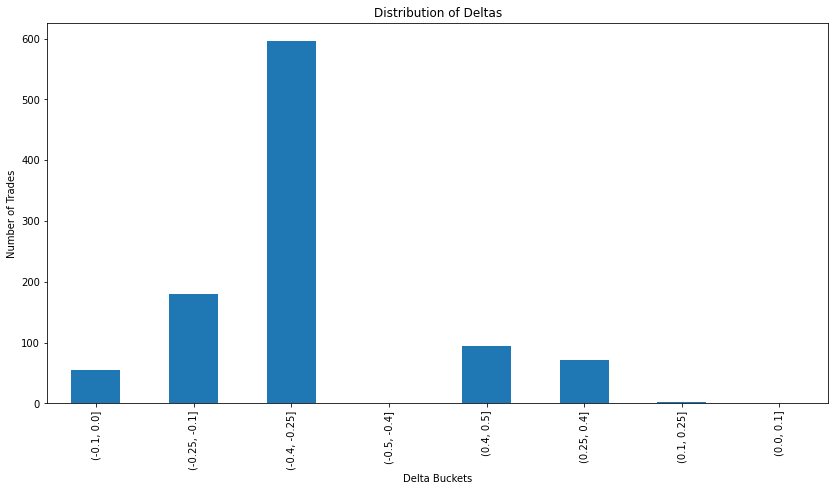

In [540]:
bins = [-.5, -.4, -.25, -.1, 0, .1, .25, .4, .5]
delta_buckets = pd.cut(test_data.de, bins)
test_data["delta_bucket"] = pd.cut(test_data.de, bins)

old_index = delta_buckets.value_counts().index
new_index = [old_index[4], old_index[1], old_index[0], old_index[7], old_index[2], old_index[3], old_index[5], old_index[6]]
delta_buckets.value_counts().loc[new_index].plot(kind='bar', title="Distribution of Deltas", figsize=(14,7))
plt.xlabel('Delta Buckets')
plt.ylabel('Number of Trades')
plt.show()

# Trade Summary

In [520]:
trade_recs_df = test_data[['expiration', 'okey_cp', 'trades','totSize_x', 'Industry', 'marketCap', 'nextEarnDate_x', 'side', 'qty','weighted_vega', 'beta', 'beta_vxx', 'delta_bucket']] #  'marketCap'
#test_data.groupby('expiration').sum()

# Greeks
trade_recs_df['de'] = test_data.de * test_data.qty * test_data.totSize_x
trade_recs_df['ga'] = test_data.ga * test_data.qty * test_data.totSize_x
trade_recs_df['ve'] = test_data.ve * test_data.qty * test_data.totSize_x
trade_recs_df['th'] = test_data.th * test_data.qty * test_data.totSize_x
trade_recs_df['va'] = test_data.va * test_data.qty * test_data.totSize_x
trade_recs_df['vo'] = test_data.vo * test_data.qty * test_data.totSize_x

trade_recs_df['weighted_vega'] = test_data.weighted_vega * test_data.qty * test_data.totSize_x
trade_recs_df['refReturn'] = test_data.refReturn * test_data.qty #* test_data.totSize_x
trade_recs_df['earnings_before_expo'] = trade_recs_df.nextEarnDate_x < trade_recs_df.expiration
trade_recs_df['beta'] = test_data.de + test_data.beta * test_data.qty * test_data.totSize_x
trade_recs_df['beta_vxx'] = test_data.de + test_data.beta_vxx * test_data.qty * test_data.totSize_x

#trade_recs_df.head(10)
print('Trade Greeks\n', trade_recs_df[['trades','de','ga','ve','th','va','vo', 'weighted_vega']].sum())

Trade Greeks
 trades           1000.000
de                975.346
ga                -53.874
ve                  0.785
th                 88.056
va                  4.553
vo                 -0.156
weighted_vega   -1630.623
dtype: float64


## Total Edge and Edge Per Trade broken down by expiration

In [541]:
expiration_trades = trade_recs_df.groupby('expiration').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
expiration_trades['avg_return_per_trades'] = expiration_trades.refReturn / expiration_trades.trades
expiration_trades[['trades', 'refReturn', 'avg_return_per_trades']]

,trades,refReturn,avg_return_per_trades
expiration,,,
2022-07-22,136,0.706,0.005
2022-07-29,99,0.509,0.005
2022-08-05,108,0.354,0.003
2022-08-12,113,0.279,0.002
2022-08-19,544,1.317,0.002


## Trades Broken down by Expiration

In [542]:
expiration_trades.loc["Total"] = 0
expiration_trades.loc["Total"] = expiration_trades.sum()
expiration_trades[[ 'trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'weighted_vega']]

,trades,de,ga,ve,th,va,vo,weighted_vega
expiration,,,,,,,,
2022-07-22 00:00:00,136.000,16.382,26.017,65.915,-77.342,-0.264,0.384,441.872
2022-07-29 00:00:00,99.000,86.635,1.692,34.166,-22.706,0.542,0.091,19.392
2022-08-05 00:00:00,108.000,119.587,-9.468,17.715,5.454,0.213,0.143,-177.236
2022-08-12 00:00:00,113.000,141.018,-14.129,-10.353,28.189,0.257,0.025,-313.327
2022-08-19 00:00:00,544.000,611.723,-57.986,-106.657,154.460,3.806,-0.799,-1601.325
Total,1000.000,975.346,-53.874,0.785,88.056,4.553,-0.156,-1630.623


## Trades Broken down by Industry

In [543]:
pd.set_option('display.max_rows', 500)

industry_trades = trade_recs_df.groupby('Industry').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
industry_trades['pct_trades'] = industry_trades.trades / industry_trades.trades.sum() * 100
industry_trades.sort_values(by=['trades'], ascending=False)

,trades,de,ga,ve,th,va,vo,refReturn,weighted_vega,pct_trades
Industry,,,,,,,,,,
Software—Application,153,232.581,-26.891,-64.493,84.187,1.382,-0.312,0.523,-685.519,15.300
Software—Infrastructure,106,155.655,-13.129,-30.254,42.315,1.011,-0.155,0.369,-354.475,10.600
Internet Content & Information,42,71.259,-10.275,16.301,-17.145,0.408,0.099,0.151,-192.124,4.200
Diagnostics & Research,27,24.127,-0.905,-2.342,6.849,0.316,-0.081,0.109,-45.365,2.700
Semiconductors,25,20.105,0.608,-3.461,0.101,0.081,-0.032,0.043,2.641,2.500
Aerospace & Defense,23,9.447,0.347,7.012,-8.943,0.145,0.029,0.104,9.454,2.300
Health Information Services,22,31.661,-3.338,-7.381,10.535,0.198,-0.034,0.084,-103.282,2.200
Packaged Foods,21,-36.799,9.643,5.420,-2.103,-0.734,0.025,0.048,86.439,2.100
Solar,21,48.175,-8.396,-5.439,7.358,0.216,-0.015,0.063,-144.252,2.100


# Trade Risk Heat Maps
### Total Puts and Calls trades

In [544]:
print("Total number of put trades:- ", test_data[test_data.okey_cp == "Put"].trades.sum())
print("Total number of call trades:- ", test_data[test_data.okey_cp == "Call"].trades.sum())
print("Total number of buy trades:- ", test_data[test_data.side == "Buy"].trades.sum())
print("Total number of sell trades:- ", test_data.trades.sum() - test_data[test_data.side == "Buy"].trades.sum())

Total number of put trades:-  831
Total number of call trades:-  169
Total number of buy trades:-  334
Total number of sell trades:-  666


#### % of Buy/Sell for Puts and Calls trades

In [545]:
print("Percentage of put buy trades:- ", round(test_data[(test_data.okey_cp == "Put") & (test_data.side == "Buy")].trades.sum()/test_data[test_data.okey_cp == "Put"].trades.sum(), 2)*100, "%")
print("Percentage of put sell trades:- ", round(1 - test_data[(test_data.okey_cp == "Put") & (test_data.side == "Buy")].trades.sum()/test_data[test_data.okey_cp == "Put"].trades.sum(),2)*100, "%")
print("Percentage of call buy trades:- ", round(test_data[(test_data.okey_cp == "Call") & (test_data.side == "Buy")].trades.sum()/test_data[test_data.okey_cp == "Call"].trades.sum(), 2)*100, "%")
print("Percentage of call sell trades:- ", round(1 - test_data[(test_data.okey_cp == "Call") & (test_data.side == "Buy")].trades.sum()/test_data[test_data.okey_cp == "Call"].trades.sum(), 2)*100, "%")

Percentage of put buy trades:-  21.0 %
Percentage of put sell trades:-  79.0 %
Percentage of call buy trades:-  95.0 %
Percentage of call sell trades:-  5.0 %


### Total Trades broken down by delta buckets for puts and calls

In [546]:
bins = [-.5, -.4, -.25, -.1, 0, .1, .25, .4, .5]
delta_groups = test_data.groupby(['expiration', pd.cut(test_data.de, bins)])
s = delta_groups.size().to_frame(name = 'count').reset_index()
delta_map = s.pivot_table('count', ['expiration'], 'de')

cols = delta_map.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
delta_map_df = delta_map[new_cols]

delta_map_df.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
delta_map_df.style.background_gradient(cmap="Blues", axis=None)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,1,2,75,0,26,30,2,0
2022-07-29 00:00:00,8,8,51,0,16,16,0,0
2022-08-05 00:00:00,0,2,87,0,13,6,0,0
2022-08-12 00:00:00,0,2,97,0,10,4,0,0
2022-08-19 00:00:00,46,166,286,0,29,16,1,0


### Buy Trades broken down by delta buckets for puts and calls

In [547]:
bins = [-.5, -.4, -.25, -.1, 0, .1, .25, .4, .5]
delta_groups = test_data[test_data.side == "Buy"].groupby(['expiration', pd.cut(test_data[test_data.side == "Buy"].de, bins)])

s = delta_groups.size().to_frame(name = 'count').reset_index()
delta_map = s.pivot_table('count', ['expiration'], 'de')
# (test_data.side == "Buy") & (test_data.okey_cp == "Call")

cols = delta_map.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
delta_map_df = delta_map[new_cols]

delta_map_df.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
delta_map_df.style.background_gradient(cmap="Greens", axis=None)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,0,1,59,0,26,30,2,0
2022-07-29 00:00:00,0,0,19,0,15,16,0,0
2022-08-05 00:00:00,0,0,22,0,12,6,0,0
2022-08-12 00:00:00,0,0,18,0,8,3,0,0
2022-08-19 00:00:00,0,6,49,0,28,14,0,0


### Sell Trades broken down by delta buckets for puts and calls

In [548]:
bins = [-.5, -.4, -.25, -.1, 0, .1, .25, .4, .5]
delta_groups = test_data[test_data.side == "Sell"].groupby(['expiration', pd.cut(test_data[test_data.side == "Sell"].de, bins)])
s = delta_groups.size().to_frame(name = 'count').reset_index()
delta_map = s.pivot_table('count', ['expiration'], 'de')

cols = delta_map.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
delta_map_df = delta_map[new_cols]

delta_map_df.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
delta_map_df.style.background_gradient(cmap="Reds", axis=None)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,1,1,16,0,0,0,0,0
2022-07-29 00:00:00,8,8,32,0,1,0,0,0
2022-08-05 00:00:00,0,2,65,0,1,0,0,0
2022-08-12 00:00:00,0,2,79,0,2,1,0,0
2022-08-19 00:00:00,46,160,237,0,1,2,1,0


### Trade Heat Map summing up Deltas

In [549]:
delta_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'de': ['sum']}).fillna(0)
heat_map_delta = delta_trade_df.unstack()

cols = heat_map_delta.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_delta = heat_map_delta[new_cols]

heat_map_delta.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_delta.style.background_gradient(cmap=cm, axis=None).set_precision(2)
#heat_map_delta.style.apply(background_gradient, cmap="RdBu", m=heat_map_delta.min().min(), M=heat_map_delta.max().max(), low=0, high=0.1).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,0.60,-0.09,-77.61,0.00,44.16,47.22,2.10,0.00
2022-07-29 00:00:00,4.41,6.78,23.26,0.00,26.62,25.57,0.00,0.00
2022-08-05 00:00:00,0.00,2.15,85.96,0.00,22.47,9.00,0.00,0.00
2022-08-12 00:00:00,0.00,3.39,120.42,0.00,14.30,2.91,0.00,0.00
2022-08-19 00:00:00,34.42,179.29,333.75,0.00,45.07,20.46,-1.27,0.00


### Trade Heat Map summing up Gamma

In [550]:
import matplotlib as mpl

cmap_reversed = mpl.cm.get_cmap('OrRd_r')

gamma_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'ga': ['sum']}).fillna(0)
heat_map_gamma = gamma_trade_df.unstack()

cols = heat_map_gamma.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_gamma = heat_map_gamma[new_cols]

heat_map_gamma.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_gamma.style.background_gradient(cmap=cmap_reversed, axis=None).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,-0.06,0.05,15.11,0.00,4.46,6.14,0.32,0.00
2022-07-29 00:00:00,-0.45,-0.36,-3.42,0.00,3.02,2.90,0.00,0.00
2022-08-05 00:00:00,0.00,-0.18,-12.76,0.00,2.68,0.79,0.00,0.00
2022-08-12 00:00:00,0.00,-0.68,-15.64,0.00,1.94,0.25,0.00,0.00
2022-08-19 00:00:00,-4.13,-20.44,-38.24,0.00,2.98,2.01,-0.17,0.00


### Trade Heat Map summing up Theta

In [551]:
cmap_reversed = mpl.cm.get_cmap('RdBu')

theta_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'th': ['sum']}).fillna(0)
heat_map_theta = theta_trade_df.unstack()

cols = heat_map_theta.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_theta = heat_map_theta[new_cols]

heat_map_theta.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_theta.style.background_gradient(cmap=cmap_reversed, axis=None).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,0.83,1.03,-35.27,0.00,-17.40,-25.04,-1.49,0.00
2022-07-29 00:00:00,5.81,8.45,7.61,0.00,-9.74,-34.83,0.00,0.00
2022-08-05 00:00:00,0.00,1.14,21.48,0.00,-7.20,-9.97,0.00,0.00
2022-08-12 00:00:00,0.00,0.76,32.54,0.00,-3.88,-1.23,0.00,0.00
2022-08-19 00:00:00,19.65,65.57,90.32,0.00,-15.03,-6.35,0.30,0.00


### Trade Heat Map summing up weighted vega exposure

In [552]:
oev_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'weighted_vega': ['sum']}).fillna(0)
heat_map_oev = oev_trade_df.unstack()

cols = heat_map_oev.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_oev = heat_map_oev[new_cols]

heat_map_oev.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_oev.style.background_gradient(cmap='Reds_r', axis=None).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,-2.84,0.22,210.69,0.00,93.66,133.21,6.92,0.00
2022-07-29 00:00:00,-20.32,-25.34,-63.73,0.00,57.68,71.09,0.00,0.00
2022-08-05 00:00:00,0.00,-7.87,-242.19,0.00,47.92,24.90,0.00,0.00
2022-08-12 00:00:00,0.00,-11.19,-340.27,0.00,29.98,8.15,0.00,0.00
2022-08-19 00:00:00,-161.13,-643.56,-946.42,0.00,97.81,56.22,-4.25,0.00


### Trade Heat Map summing up Vanna

In [553]:
vanna_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'va': ['sum']}).fillna(0)
heat_map_vanna = vanna_trade_df.unstack()

cols = heat_map_vanna.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_vanna = heat_map_vanna[new_cols]

heat_map_vanna.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_vanna.style.background_gradient(cmap='Blues', axis=None).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,0.02,-0.01,-1.38,0.00,0.17,0.87,0.06,0.00
2022-07-29 00:00:00,0.13,0.14,-0.27,0.00,0.11,0.43,0.00,0.00
2022-08-05 00:00:00,0.00,0.02,-0.05,0.00,0.09,0.15,0.00,0.00
2022-08-12 00:00:00,0.00,0.03,0.10,0.00,0.06,0.07,0.00,0.00
2022-08-19 00:00:00,0.81,2.05,0.36,0.00,0.25,0.41,-0.07,0.00


### Trade Heat Map summing up Vomma

In [554]:
vomma_trade_df = trade_recs_df.groupby(['expiration', 'delta_bucket']).agg({'vo': ['sum']}).fillna(0)
heat_map_vomma = vomma_trade_df.unstack()

cols = heat_map_vomma.columns.tolist()
new_cols = [cols[3], cols[2], cols[1], cols[0], cols[7], cols[6], cols[5], cols[4]]
heat_map_vomma = heat_map_vomma[new_cols]

heat_map_vomma.columns = ['<=10d P', '10d-25d P', '25d-40d P', '40d-ATM P', 'ATM-40d C', '25d-40d C', '10d-25d C', '<=10d C']
heat_map_vomma.style.background_gradient(cmap='Blues', axis=None).set_precision(2)

,<=10d P,10d-25d P,25d-40d P,40d-ATM P,ATM-40d C,25d-40d C,10d-25d C,<=10d C
expiration,,,,,,,,
2022-07-22 00:00:00,-0.01,-0.00,0.21,0.00,0.01,0.15,0.02,0.00
2022-07-29 00:00:00,-0.08,-0.07,0.06,0.00,0.00,0.17,0.00,0.00
2022-08-05 00:00:00,0.00,-0.00,0.07,0.00,0.00,0.08,0.00,0.00
2022-08-12 00:00:00,0.00,-0.00,0.00,0.00,0.00,0.02,0.00,0.00
2022-08-19 00:00:00,-0.36,-0.52,-0.01,0.00,0.02,0.10,-0.03,0.00


# Buys vs Sells Breakdown

### Total Edge and Edge Per Trade for Buys broken down by expiration

In [555]:
buy_expiration_trades = buys_df.groupby('expiration').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
buy_expiration_trades['avg_return_per_trades'] = buy_expiration_trades.refReturn / buy_expiration_trades.trades
buy_expiration_trades[['trades', 'refReturn', 'avg_return_per_trades']]

,trades,refReturn,avg_return_per_trades
expiration,,,
2022-07-22,118,0.519,0.004
2022-07-29,50,0.113,0.002
2022-08-05,40,0.089,0.002
2022-08-12,29,0.049,0.002
2022-08-19,97,0.132,0.001


### Total Edge and Edge Per Trade for Sells broken down by expiration

In [556]:
sell_expiration_trades = sells_df.groupby('expiration').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
sell_expiration_trades['avg_return_per_trades'] = sell_expiration_trades.refReturn / sell_expiration_trades.trades
sell_expiration_trades[['trades', 'refReturn', 'avg_return_per_trades']]

,trades,refReturn,avg_return_per_trades
expiration,,,
2022-07-22,18,0.186,0.010
2022-07-29,49,0.396,0.008
2022-08-05,68,0.265,0.004
2022-08-12,84,0.230,0.003
2022-08-19,447,1.185,0.003


## Greeks of Buy Trades and Sell Trades

In [557]:
buys_df = trade_recs_df[trade_recs_df.side == 'Buy']
sells_df = trade_recs_df[trade_recs_df.side == 'Sell']

print('Buys\n', buys_df[['trades', 'de', 'ga', 've', 'th', 'va', 'vo']].sum())
print('\nSells\n', sells_df[['trades', 'de', 'ga', 've', 'th', 'va', 'vo']].sum())

Buys
 trades    334.000
de        -41.404
ga         72.526
ve        285.692
th       -254.377
va         -1.696
vo          1.444
dtype: float64

Sells
 trades    666.000
de       1016.750
ga       -126.399
ve       -284.907
th        342.433
va          6.249
vo         -1.600
dtype: float64


## Buy Trades broken down by Industry

In [558]:
buy_industry_trades = buys_df.groupby('Industry').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
buy_industry_trades['pct_trades'] = buy_industry_trades.trades / buy_industry_trades.trades.sum() * 100
buy_industry_trades.sort_values(by=['trades'], ascending=False)

,trades,de,ga,ve,th,va,vo,refReturn,weighted_vega,pct_trades
Industry,,,,,,,,,,
Household & Personal Products,17,-36.545,4.630,13.470,-9.534,-0.548,0.087,0.090,99.555,5.090
Healthcare Plans,16,-21.889,2.097,17.092,-13.185,-0.304,0.082,0.038,59.917,4.790
Aerospace & Defense,15,0.087,0.874,13.352,-14.404,0.057,0.085,0.086,38.480,4.491
Packaged Foods,15,-38.538,10.304,8.068,-4.285,-0.671,0.063,0.031,109.828,4.491
Software—Infrastructure,14,23.226,2.947,7.875,-6.125,0.188,0.034,0.020,53.306,4.192
Specialty Industrial Machinery,12,-11.915,3.098,8.971,-7.023,-0.192,0.042,0.034,71.507,3.593
Semiconductors,12,3.701,1.651,7.128,-8.518,-0.047,0.020,0.015,53.021,3.593
Credit Services,12,22.515,1.878,6.006,-10.024,0.217,0.027,0.018,55.797,3.593
Utilities—Regulated Electric,10,-13.928,3.027,8.650,-3.614,-0.337,0.081,0.031,67.283,2.994


## Sell Trades broken down by Industry

In [559]:
sell_industry_trades = sells_df.groupby('Industry').sum()[['trades', 'de', 'ga', 've', 'th', 'va', 'vo', 'refReturn', 'weighted_vega']]
sell_industry_trades['pct_trades'] = sell_industry_trades.trades / sell_industry_trades.trades.sum() * 100
sell_industry_trades.sort_values(by=['trades'], ascending=False)

,trades,de,ga,ve,th,va,vo,refReturn,weighted_vega,pct_trades
Industry,,,,,,,,,,
Software—Application,150,227.792,-27.181,-66.618,85.667,1.363,-0.313,0.522,-695.519,22.523
Software—Infrastructure,92,132.429,-16.076,-38.129,48.440,0.823,-0.189,0.349,-407.781,13.814
Internet Content & Information,38,67.266,-10.291,-10.506,15.617,0.354,-0.048,0.147,-203.873,5.706
Health Information Services,22,31.661,-3.338,-7.381,10.535,0.198,-0.034,0.084,-103.282,3.303
Diagnostics & Research,21,18.031,-1.123,-10.191,11.366,0.240,-0.121,0.096,-60.731,3.153
Solar,21,48.175,-8.396,-5.439,7.358,0.216,-0.015,0.063,-144.252,3.153
Resorts & Casinos,20,45.310,-5.987,-7.139,8.346,0.255,-0.026,0.044,-131.292,3.003
Internet Retail,16,31.751,-3.251,-3.966,9.862,0.050,-0.003,0.094,-88.134,2.402
Semiconductors,13,16.404,-1.043,-10.588,8.619,0.129,-0.052,0.027,-50.380,1.952


## Buy and Sell Trades broken down by Industry Charts

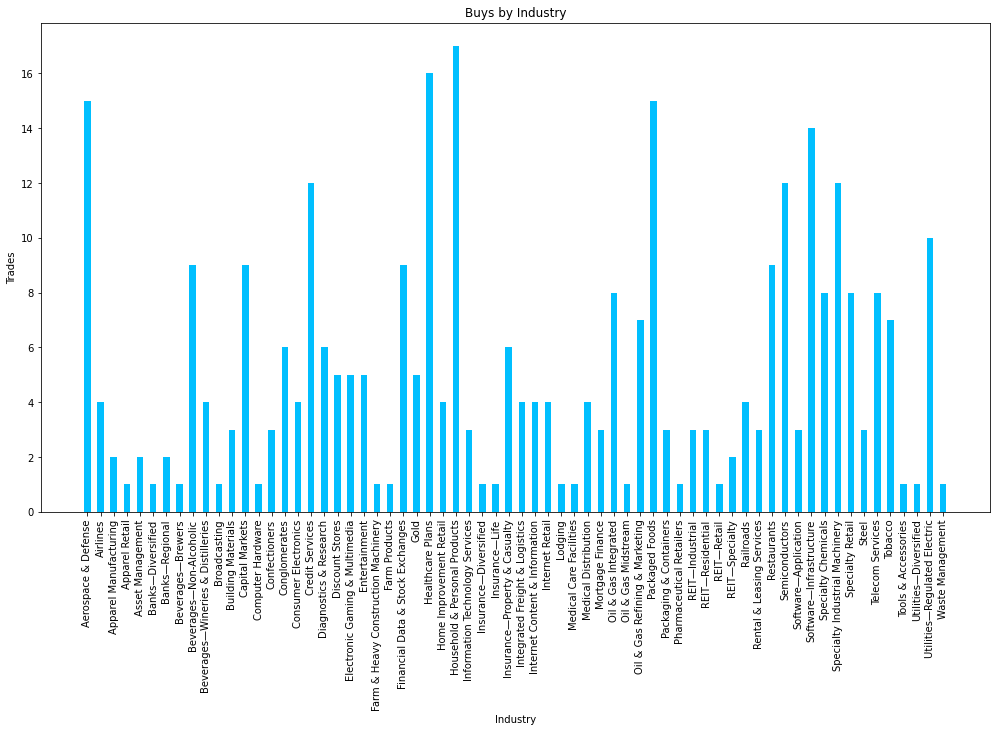

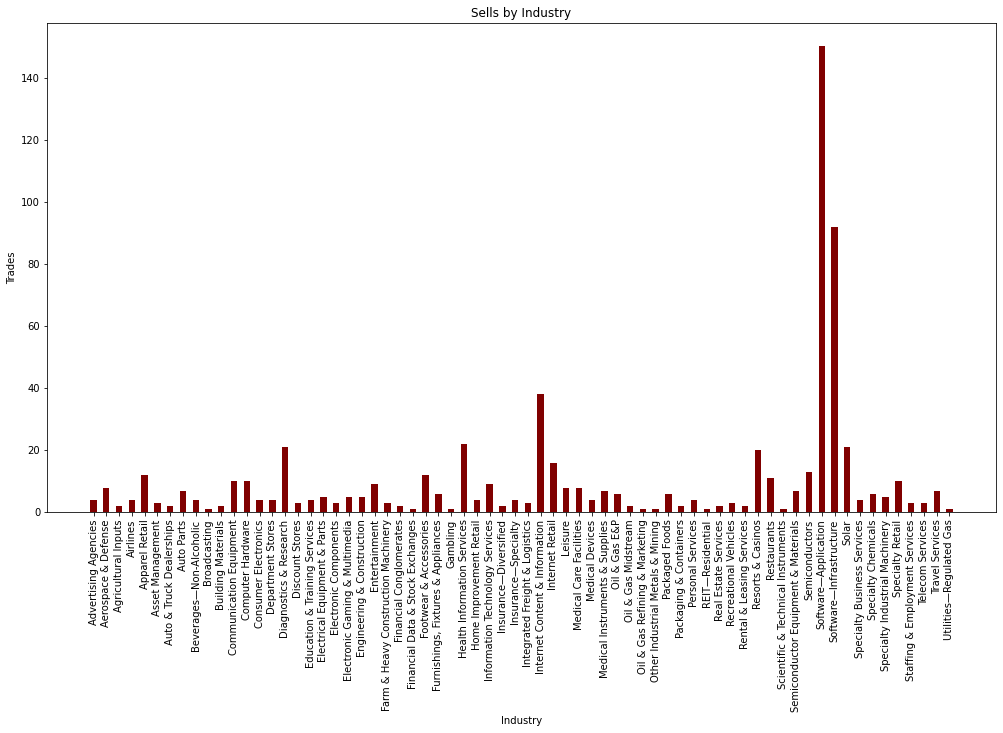

In [560]:
fig = plt.gcf()
plt.ylabel('Trades')
plt.xlabel('Industry')
plt.title('Buys by Industry')
fig.set_size_inches(17, 9)
plt.bar(trade_recs_df[trade_recs_df.side == "Buy"].groupby('Industry').sum()['trades'].index, trade_recs_df[trade_recs_df.side == "Buy"].groupby('Industry').sum()['trades'].values, width=0.5, color='deepskyblue')
plt.xticks(rotation = 90) 
plt.show()

fig = plt.gcf()
plt.ylabel('Trades')
plt.xlabel('Industry')
plt.title('Sells by Industry')
fig.set_size_inches(17, 9)
plt.bar(trade_recs_df[trade_recs_df.side == "Sell"].groupby('Industry').sum()['trades'].index, trade_recs_df[trade_recs_df.side == "Sell"].groupby('Industry').sum()['trades'].values, width=0.5, color='maroon')
plt.xticks(rotation = 90) 
plt.show()

## Sell Trades with Earnings before Expiration

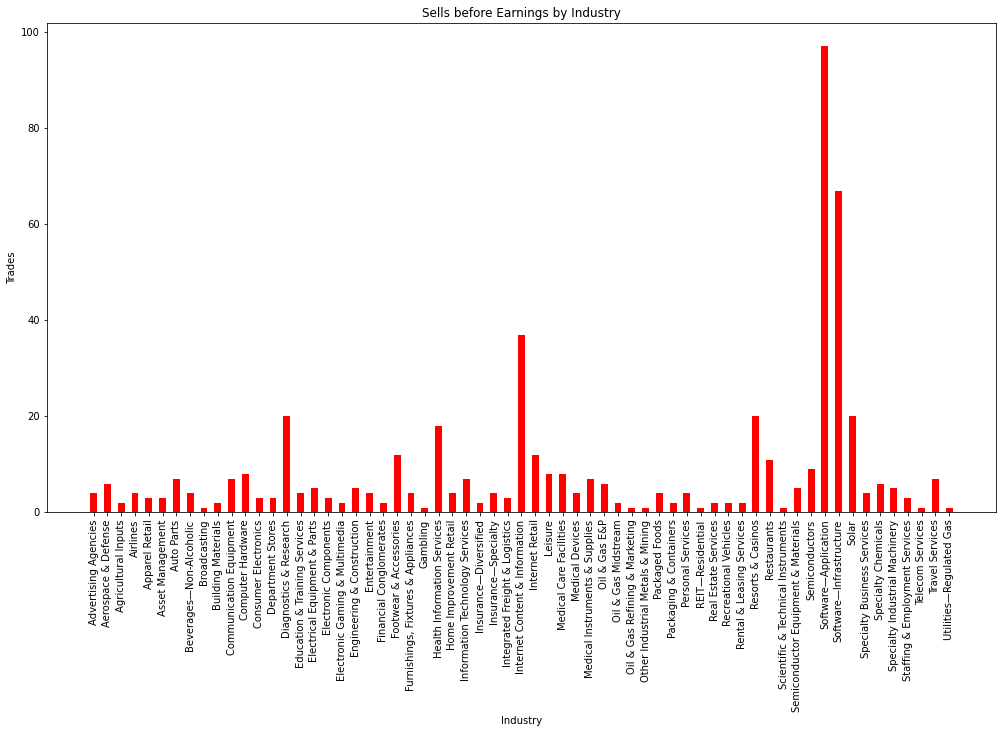

In [561]:
sell_before_earnings = trade_recs_df[(trade_recs_df.side == "Sell") & (trade_recs_df.earnings_before_expo == True)]
sell_before_earnings_df = sell_before_earnings.groupby('Industry').sum()['trades']
fig = plt.gcf()
plt.ylabel('Trades')
plt.xlabel('Industry')
plt.title('Sells before Earnings by Industry')
fig.set_size_inches(17, 9)
        
plt.bar(sell_before_earnings_df.index, sell_before_earnings_df.values, width=0.5, color='red')
plt.xticks(rotation = 90) 
plt.show()